Loading dataset...
Dataset shape: (2617, 4)
label
Normal        1019
Depression     800
Anxiety        798
Name: count, dtype: int64
Classes: ['Anxiety' 'Depression' 'Normal']
Training samples: 2093
Testing samples: 524
Extracting features with TF-IDF...
TF-IDF shape: (2093, 5000)

Generating learning curve visualization...


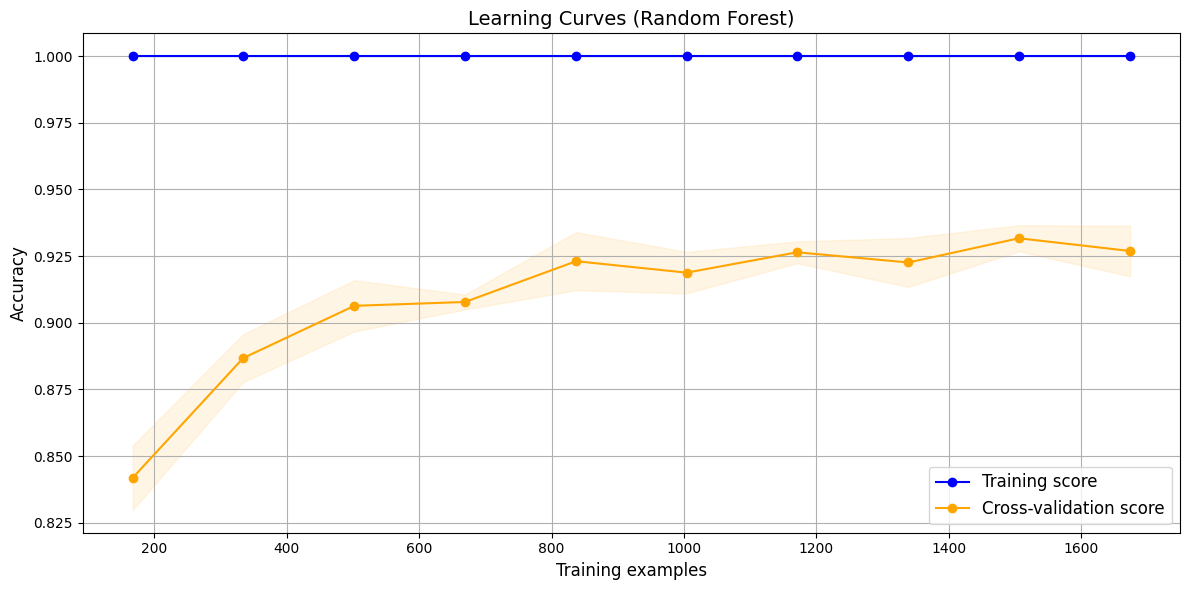


Generating validation curve for max_depth...


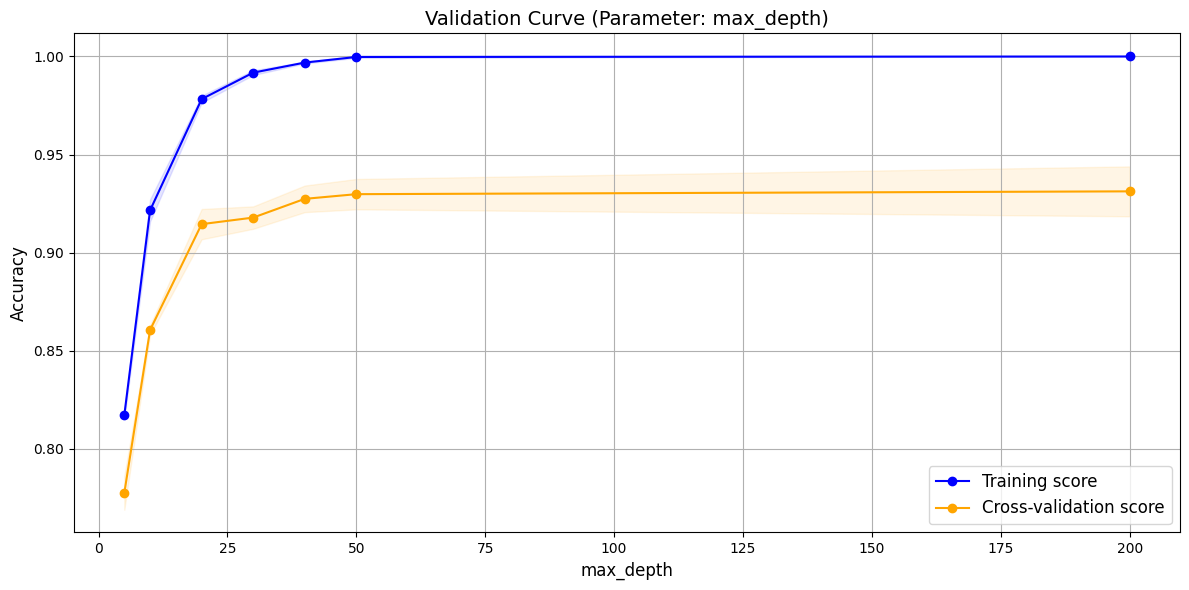


Generating validation curve for n_estimators...


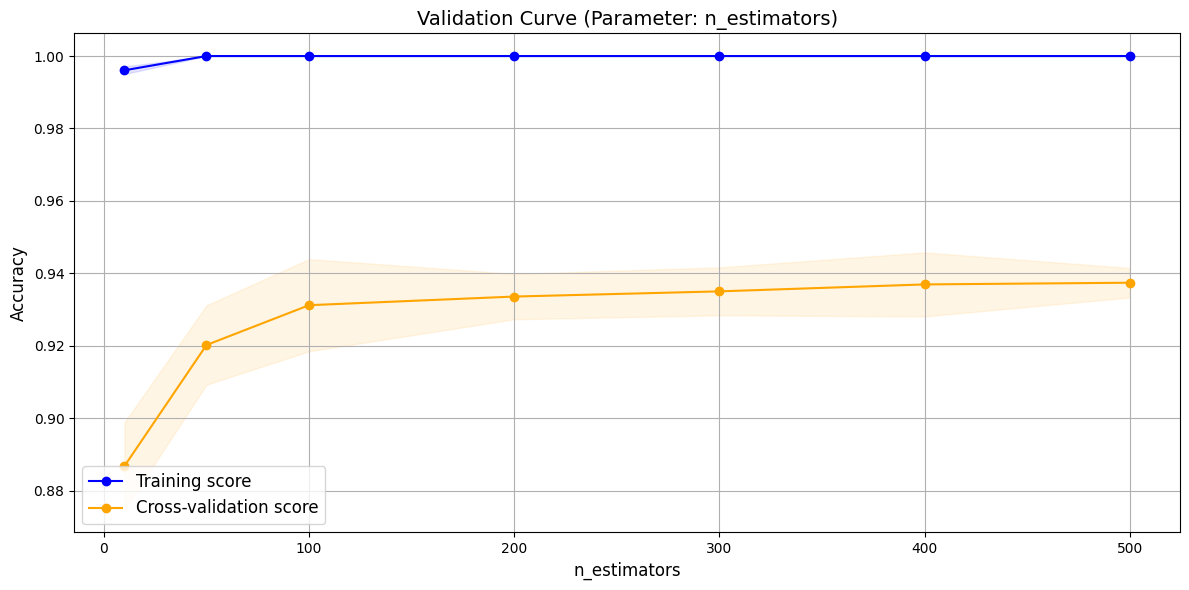

Performing grid search for hyperparameter tuning...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.9202
Training final model with best parameters...

Classification Report:
              precision    recall  f1-score   support

     Anxiety     0.9257    0.8562    0.8896       160
  Depression     0.9167    0.8938    0.9051       160
      Normal     0.9182    0.9902    0.9528       204

    accuracy                         0.9198       524
   macro avg     0.9202    0.9134    0.9158       524
weighted avg     0.9200    0.9198    0.9189       524

Test accuracy: 0.9198


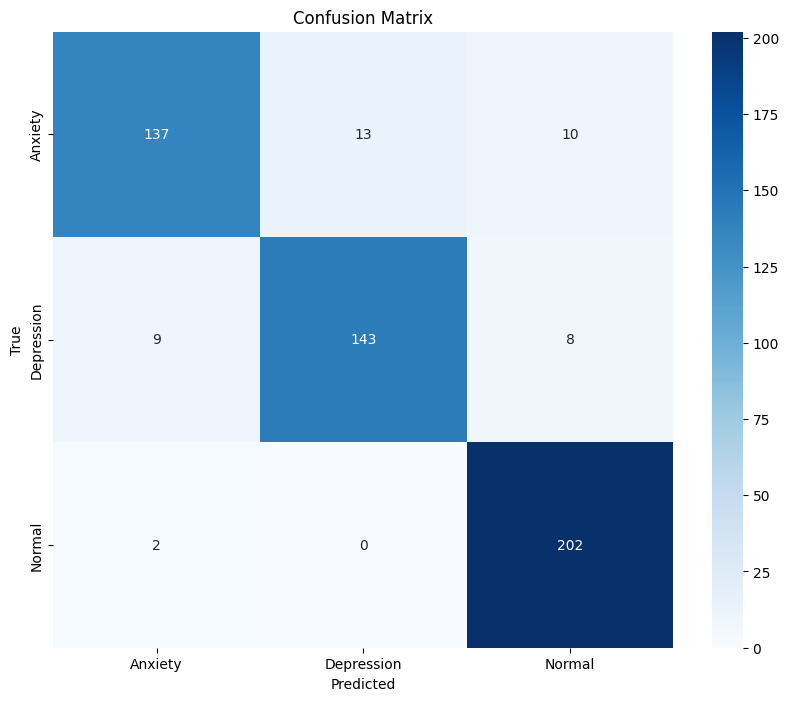


Top 20 most important features:
වෙලා: 0.0432
කාංසාව: 0.0238
වෙනවා: 0.0236
දැනෙනවා: 0.0192
බය: 0.0191
මාව: 0.0188
බැහැ: 0.0184
ඉන්න: 0.0172
කිසිම: 0.0168
එය: 0.0164
බැරි: 0.0164
හැම: 0.0159
ජීවිතේ: 0.0158
බයයි: 0.0154
හිතෙනවා: 0.0136
වෙයි: 0.0134
තරම්: 0.0131
හිස්: 0.0128
විතරයි: 0.0114
නින්ද: 0.0109


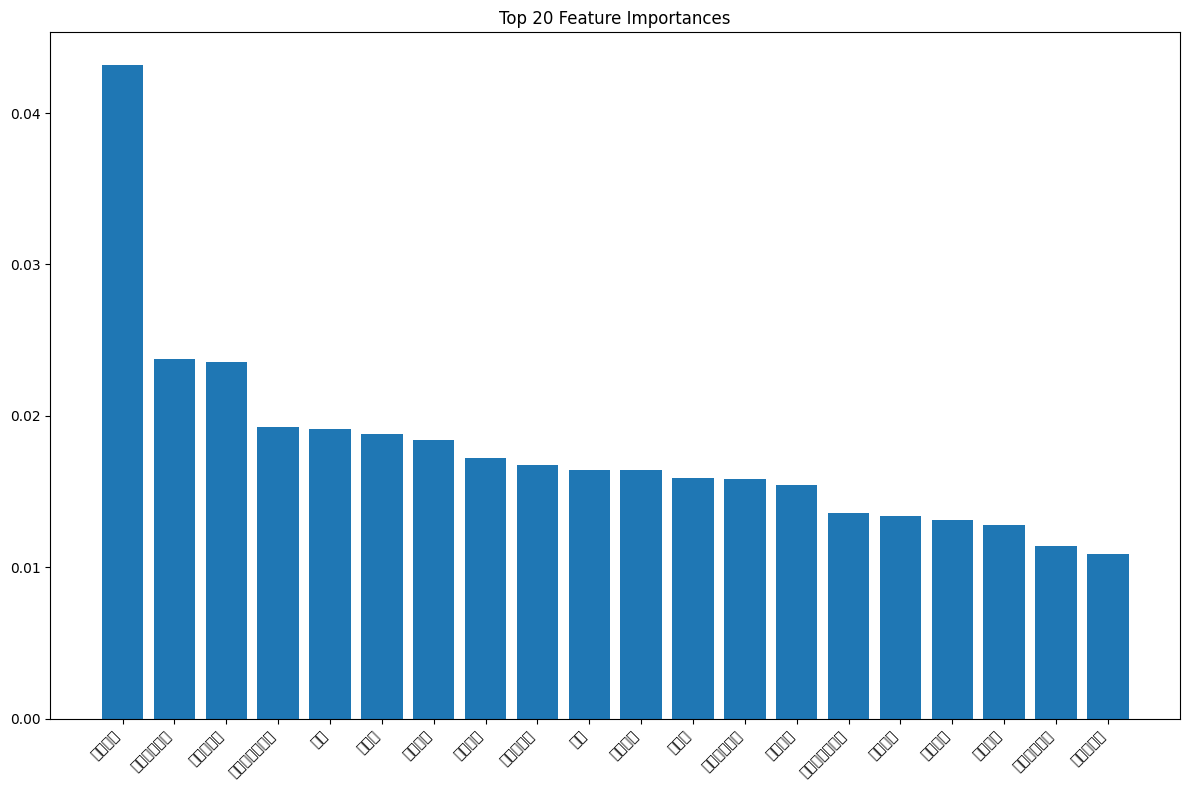


Analyzing feature importance distribution...


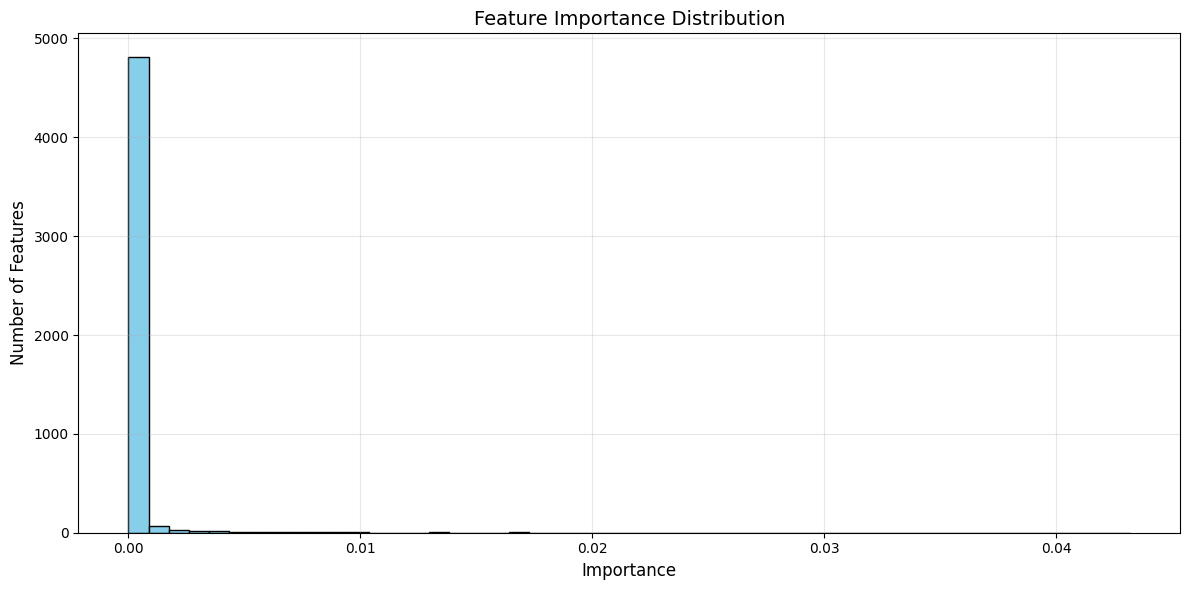

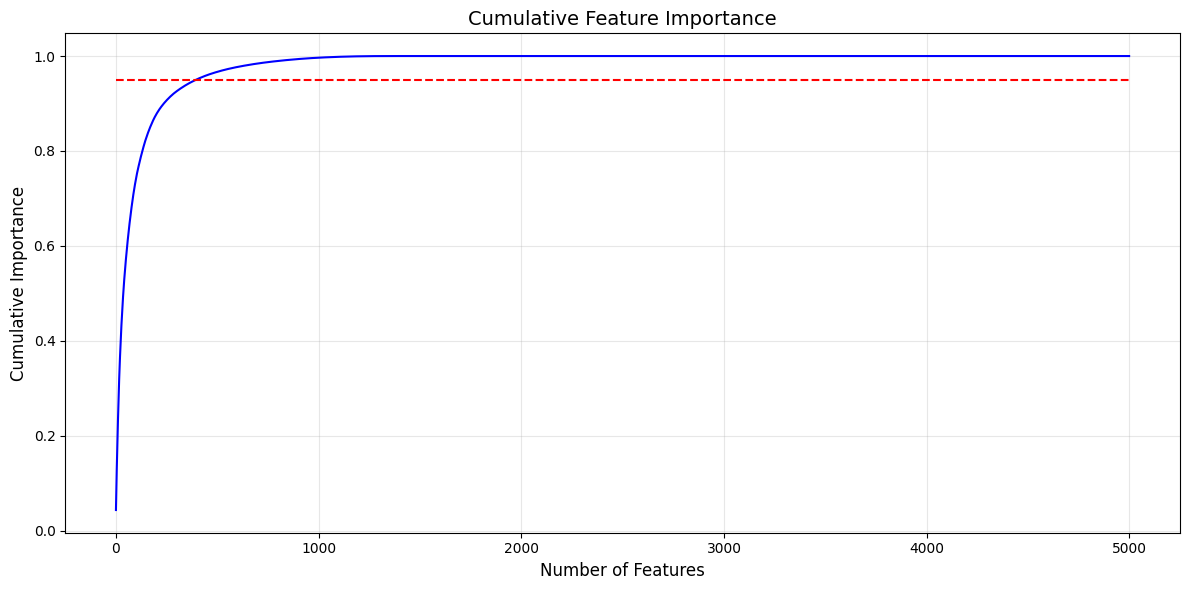

Number of features needed for 95% importance: 396 out of 5000

Generating cross-validation accuracy distribution...


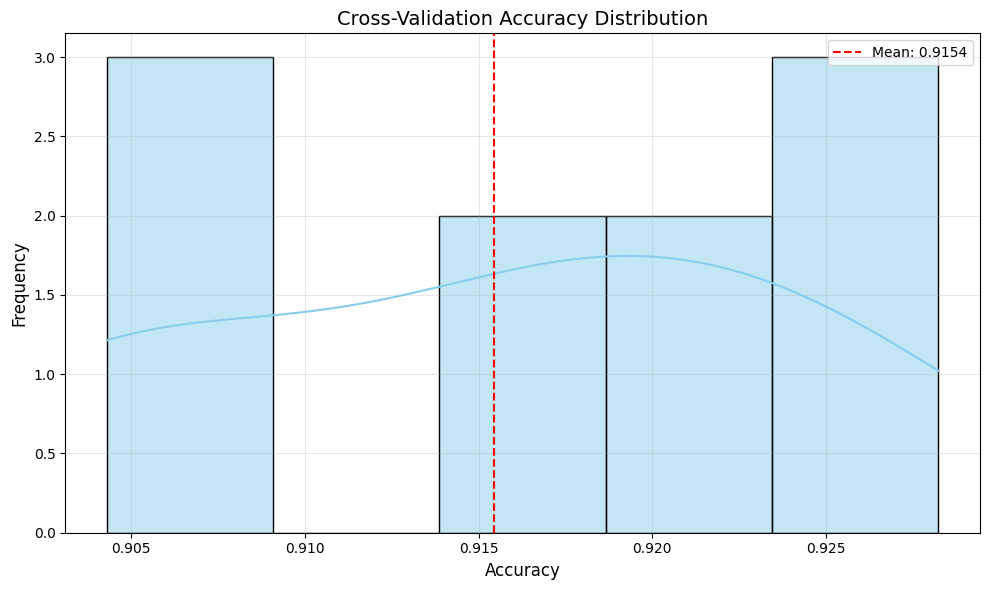

Cross-validation accuracy: 0.9154 ± 0.0083
Min: 0.9043, Max: 0.9282

Comparing train vs test metrics...


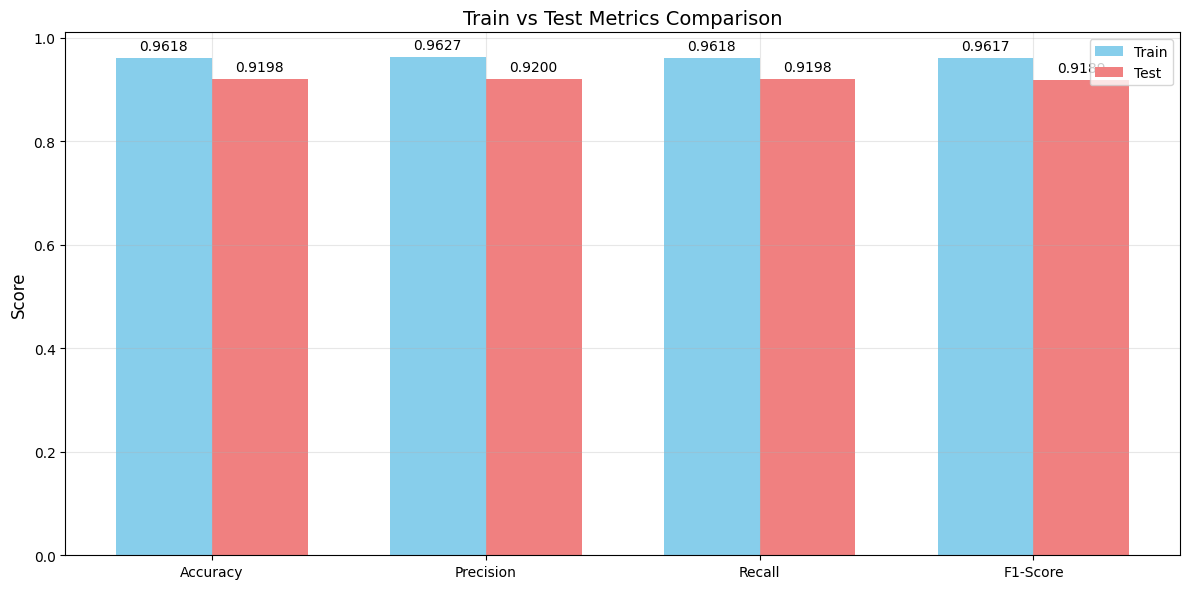

Overfitting Gap (Train - Test):
Accuracy gap: 0.0419
Precision gap: 0.0427
Recall gap: 0.0419
F1-Score gap: 0.0427

Saving model, vectorizer, and label encoder...
Model saved to sinhala_mental_health_rf_model.pkl
Vectorizer saved to sinhala_mental_health_tfidf.pkl
Label encoder saved to sinhala_mental_health_label_encoder.pkl


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import re
import pickle
import lime
import lime.lime_text
import os
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load the dataset
print("Loading dataset...")
df = pd.read_csv("/Users/tharanidissanayake/Documents/sinhala-mental-health-detection-irp/Data/Preprocessed_Manual_Labelled_Dataset .csv")
print(f"Dataset shape: {df.shape}")
print(df['label'].value_counts())

# Preprocess Sinhala text
def preprocess_sinhala_text(text):
    if isinstance(text, str):
        # Keep only Sinhala Unicode range (0D80-0DFF) and basic punctuation
        text = re.sub(r'[^\u0D80-\u0DFF\s.,!?]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# Apply preprocessing
df['preprocessed_text'] = df['cleaned_text'].apply(preprocess_sinhala_text)

# Encode the labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
print(f"Classes: {label_encoder.classes_}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['preprocessed_text'], 
    df['encoded_label'],
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=df['encoded_label']
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Feature extraction with TF-IDF
print("Extracting features with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit features to prevent overfitting
    ngram_range=(1, 3),  # Include up to trigrams for better context
    token_pattern=r'[^\s]+',  # Pattern that works well for Sinhala
    min_df=3,  # Ignore terms that appear in fewer than 3 documents
    max_df=0.9,  # Ignore terms that appear in more than 90% of documents
    strip_accents=None,
    sublinear_tf=True  # Apply sublinear tf scaling (logarithmic)
)

# Transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")

# Define visualization functions for overfitting detection
def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1):
    """
    Plot learning curves to detect overfitting
    """
    plt.figure(figsize=(12, 6))
    
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv, 
        n_jobs=n_jobs,
        scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    
    # Plot learning curve
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="blue")
    plt.fill_between(train_sizes, 
                     validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, 
                     alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="orange", label="Cross-validation score")
    
    plt.title("Learning Curves (Random Forest)", fontsize=14)
    plt.xlabel("Training examples", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True)
    plt.legend(loc="best", fontsize=12)
    plt.tight_layout()
    plt.savefig('rf_learning_curve.png')
    plt.show()

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, n_jobs=-1):
    """
    Plot validation curves to show parameter impact on overfitting
    """
    plt.figure(figsize=(12, 6))
    
    train_scores, validation_scores = validation_curve(
        estimator, X, y, 
        param_name=param_name,
        param_range=param_range,
        cv=cv, 
        scoring='accuracy', 
        n_jobs=n_jobs
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    
    # Plot validation curve
    plt.fill_between(param_range, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="blue")
    plt.fill_between(param_range, 
                     validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, 
                     alpha=0.1, color="orange")
    plt.plot(param_range, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(param_range, validation_scores_mean, 'o-', color="orange", label="Cross-validation score")
    
    plt.title(f"Validation Curve (Parameter: {param_name})", fontsize=14)
    plt.xlabel(param_name, fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True)
    plt.legend(loc="best", fontsize=12)
    plt.tight_layout()
    plt.savefig(f'rf_validation_curve_{param_name}.png')
    plt.show()

def plot_feature_importance_distribution(model, feature_names):
    """
    Plot feature importance distribution to detect if model relies on too few features
    """
    importances = model.feature_importances_
    
    plt.figure(figsize=(12, 6))
    
    # Plot feature importance distribution
    plt.hist(importances, bins=50, color='skyblue', edgecolor='black')
    plt.title("Feature Importance Distribution", fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Number of Features", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rf_feature_importance_distribution.png')
    plt.show()
    
    # Plot cumulative importance
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_indices]
    cumulative_importances = np.cumsum(sorted_importances)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(cumulative_importances)), cumulative_importances, 'b-')
    plt.hlines(y=0.95, xmin=0, xmax=len(cumulative_importances), color='r', linestyles='--')
    plt.title('Cumulative Feature Importance', fontsize=14)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rf_cumulative_importance.png')
    plt.show()
    
    # Print number of features for 95% importance
    n_features_95 = np.where(cumulative_importances >= 0.95)[0][0] + 1
    print(f"Number of features needed for 95% importance: {n_features_95} out of {len(feature_names)}")

def plot_cv_accuracy_distribution(estimator, X, y, cv=10, n_jobs=-1):
    """
    Plot cross-validation accuracy distribution to check for model instability
    """
    # Get cross-validation scores
    cv_scores = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy', n_jobs=n_jobs)
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram
    sns.histplot(cv_scores, kde=True, color='skyblue')
    plt.axvline(np.mean(cv_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
    plt.title('Cross-Validation Accuracy Distribution', fontsize=14)
    plt.xlabel('Accuracy', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rf_cv_accuracy_distribution.png')
    plt.show()
    
    # Print statistics
    print(f"Cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print(f"Min: {np.min(cv_scores):.4f}, Max: {np.max(cv_scores):.4f}")

def plot_train_vs_test_metrics(model, X_train, y_train, X_test, y_test):
    """
    Compare train and test metrics to directly measure overfitting
    """
    # Predict on train and test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        y_train, y_train_pred, average='weighted')
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='weighted')
    
    # Create data for plotting
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    train_values = [train_acc, train_precision, train_recall, train_f1]
    test_values = [test_acc, test_precision, test_recall, test_f1]
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, train_values, width, label='Train', color='skyblue')
    plt.bar(x + width/2, test_values, width, label='Test', color='lightcoral')
    
    # Add text labels
    for i in range(len(metrics)):
        plt.text(i - width/2, train_values[i] + 0.01, f'{train_values[i]:.4f}', 
                 ha='center', va='bottom', fontsize=10)
        plt.text(i + width/2, test_values[i] + 0.01, f'{test_values[i]:.4f}', 
                 ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Score', fontsize=12)
    plt.title('Train vs Test Metrics Comparison', fontsize=14)
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rf_train_vs_test_metrics.png')
    plt.show()
    
    # Print the difference (overfitting gap)
    print("Overfitting Gap (Train - Test):")
    print(f"Accuracy gap: {train_acc - test_acc:.4f}")
    print(f"Precision gap: {train_precision - test_precision:.4f}")
    print(f"Recall gap: {train_recall - test_recall:.4f}")
    print(f"F1-Score gap: {train_f1 - test_f1:.4f}")

# Generate learning curve visualization before hyperparameter tuning
print("\nGenerating learning curve visualization...")
rf_for_viz = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE
)
plot_learning_curve(rf_for_viz, X_train_tfidf, y_train, cv=5)

# Generate validation curves for important parameters
print("\nGenerating validation curve for max_depth...")
max_depth_range = [5, 10, 20, 30, 40, 50, 200]
plot_validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    X_train_tfidf, y_train,
    "max_depth", 
    max_depth_range,
    cv=5
)

print("\nGenerating validation curve for n_estimators...")
n_estimators_range = [10, 50, 100, 200, 300, 400, 500]
plot_validation_curve(
    RandomForestClassifier(random_state=RANDOM_STATE),
    X_train_tfidf, y_train,
    "n_estimators", 
    n_estimators_range,
    cv=5
)

# Cross-validation for parameter tuning
param_grid = {
    'n_estimators': [200, 300, 400],  # More trees can help reduce overfitting
    'max_depth': [10, 15, 20],  # Limit depth to prevent memorization
    'min_samples_split': [5, 10, 15],  # Require more samples before splitting
    'min_samples_leaf': [3, 4, 5],  # Require more samples in each leaf
    'max_features': ['sqrt', 'log2', 0.3],  # Limit features considered per split
    'bootstrap': [True],  # Always use bootstrap sampling
    'class_weight': ['balanced'],  # Maintain class balance
    'max_samples': [0.7, 0.8, 0.9]  # Use bootstrap sampling with fewer samples
}

# Use a smaller parameter grid for faster execution (uncomment if needed)
"""
param_grid = {
    'n_estimators': [200],
    'max_depth': [None, 20],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'class_weight': ['balanced']
}
"""

# Initialize Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Perform grid search with cross-validation (this might take some time)
print("Performing grid search for hyperparameter tuning...")
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True),  # Enable OOB scoring
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

# Print best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_rf = grid_search.best_estimator_

# Train the best model on the full training data
print("Training final model with best parameters...")
best_rf.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred = best_rf.predict(X_test_tfidf)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=4))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('rf_confusion_matrix.png')
plt.show()

# Feature importance analysis
print("\nTop 20 most important features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top features
for i in range(min(20, len(feature_names))):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(min(20, len(feature_names))), importances[indices[:20]])
plt.xticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()

# Additional overfitting analysis after model training
print("\nAnalyzing feature importance distribution...")
plot_feature_importance_distribution(best_rf, feature_names)

print("\nGenerating cross-validation accuracy distribution...")
plot_cv_accuracy_distribution(best_rf, X_train_tfidf, y_train, cv=10)

print("\nComparing train vs test metrics...")
plot_train_vs_test_metrics(best_rf, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Save the model, vectorizer, and label encoder for future use
print("\nSaving model, vectorizer, and label encoder...")
model_file = 'sinhala_mental_health_rf_model.pkl'
vectorizer_file = 'sinhala_mental_health_tfidf.pkl'
label_encoder_file = 'sinhala_mental_health_label_encoder.pkl'

with open(model_file, 'wb') as f:
    pickle.dump(best_rf, f)
    
with open(vectorizer_file, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open(label_encoder_file, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"Model saved to {model_file}")
print(f"Vectorizer saved to {vectorizer_file}")
print(f"Label encoder saved to {label_encoder_file}")

# Function for predicting new text
def predict_mental_health(text, vectorizer, model, label_encoder):
    """
    Predict mental health category from text
    
    Parameters:
    -----------
    text : str
        Input text to classify
    vectorizer : TfidfVectorizer
        Fitted vectorizer for feature extraction
    model : RandomForestClassifier
        Trained classifier
    label_encoder : LabelEncoder
        Encoder for class labels
        
    Returns:
    --------
    dict
        Dictionary with prediction results
    """
    # Preprocess the text
    preprocessed_text = preprocess_sinhala_text(text)
    
    # Vectorize the text
    text_tfidf = vectorizer.transform([preprocessed_text])
    
    # Make prediction
    prediction = model.predict(text_tfidf)[0]
    probabilities = model.predict_proba(text_tfidf)[0]
    
    # Get the predicted class
    predicted_class = label_encoder.inverse_transform([prediction])[0]
    
    # Return results
    result = {
        'class': predicted_class,
        'confidence': float(probabilities[prediction]),
        'probabilities': {
            label_encoder.classes_[i]: float(probabilities[i])
            for i in range(len(label_encoder.classes_))
        }
    }
    
    return result

# Enhanced LIME explanation function
def explain_prediction_with_lime(text, vectorizer, model, label_encoder, explainer=None, 
                                num_features=10, num_samples=5000, save_path=None):
    """
    Generate and visualize LIME explanation for a prediction
    
    Parameters:
    -----------
    text : str
        Input text to explain
    vectorizer : TfidfVectorizer
        Fitted vectorizer for feature extraction
    model : RandomForestClassifier
        Trained classifier
    label_encoder : LabelEncoder
        Encoder for class labels
    explainer : lime.lime_text.LimeTextExplainer, optional
        Lime explainer instance (creates new one if None)
    num_features : int, optional
        Number of features to include in explanation
    num_samples : int, optional
        Number of samples for LIME perturbation
    save_path : str, optional
        Path to save visualization (if None, just displays)
        
    Returns:
    --------
    tuple
        (explanation, html_explanation, prediction_result)
    """
    # Preprocess text
    preprocessed_text = preprocess_sinhala_text(text)
    
    # Create explainer if not provided
    if explainer is None:
        explainer = lime.lime_text.LimeTextExplainer(
            class_names=label_encoder.classes_,
            split_expression=lambda x: x.split(),  # Custom tokenization for Sinhala
            bow=False  # Don't force bag of words
        )
    
    # Function for prediction probabilities
    def predict_proba_fn(texts):
        return model.predict_proba(vectorizer.transform(texts))
    
    # Get prediction
    prediction_result = predict_mental_health(
        preprocessed_text, vectorizer, model, label_encoder
    )
    
    # Find predicted class index
    prediction_idx = list(label_encoder.classes_).index(prediction_result['class'])
    
    # Generate explanation
    explanation = explainer.explain_instance(
        preprocessed_text,
        predict_proba_fn,
        num_features=num_features,
        num_samples=num_samples,
        top_labels=len(label_encoder.classes_)
    )
    
    # Generate HTML visualization
    html_explanation = explanation.as_html(labels=(prediction_idx,))
    
    # Save explanation if requested
    if save_path:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write(html_explanation)
    
    # Process explanation data for display
    exp_data = {
        'text': preprocessed_text,
        'prediction': prediction_result['class'],
        'confidence': prediction_result['confidence'],
        'explanations': {}
    }
    
    # Get explanations for all classes
    for i, class_name in enumerate(label_encoder.classes_):
        features = explanation.as_list(label=i)
        sorted_features = sorted(features, key=lambda x: abs(x[1]), reverse=True)
        
        exp_data['explanations'][class_name] = {
            'probability': prediction_result['probabilities'][class_name],
            'features': sorted_features
        }
    
    # Create bar chart of class probabilities
    plt.figure(figsize=(10, 5))
    classes = list(prediction_result['probabilities'].keys())
    probs = list(prediction_result['probabilities'].values())
    
    colors = ['green' if c == prediction_result['class'] else 'lightgray' for c in classes]
    
    plt.bar(classes, probs, color=colors)
    plt.title('Prediction Probabilities')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    for i, v in enumerate(probs):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.html', '_probs.png'))
    plt.show()
    
    # Return everything
    return explanation, html_explanation, exp_data

# Create a function to load unseen data and test the model
def test_on_unseen_data(model, vectorizer, label_encoder, data_path=None, sample_size=10):
    """
    Test model on completely unseen data
    
    Parameters:
    -----------
    model : RandomForestClassifier
        Trained classifier
    vectorizer : TfidfVectorizer
        Fitted vectorizer
    label_encoder : LabelEncoder
        Fitted label encoder
    data_path : str, optional
        Path to CSV with unseen data (must have 'text' and 'label' columns)
        If None, will use held-out test data
    sample_size : int, optional
        Number of samples to test (if using test data)
        
    Returns:
    --------
    dict
        Dictionary with test results
    """
    if data_path and os.path.exists(data_path):
        # Load unseen data
        try:
            unseen_df = pd.read_csv(data_path)
            if 'text' not in unseen_df.columns or 'label' not in unseen_df.columns:
                print("Error: Unseen data must have 'text' and 'label' columns")
                return None
            
            # Prepare data
            X_unseen = unseen_df['text']
            y_unseen = unseen_df['label']
            
            # Encode labels if they match our known classes
            y_unseen_encoded = []
            for label in y_unseen:
                if label in label_encoder.classes_:
                    y_unseen_encoded.append(label_encoder.transform([label])[0])
                else:
                    print(f"Warning: Unseen label '{label}' not in training data")
                    y_unseen_encoded.append(-1)  # Mark as unknown
            
            y_unseen_encoded = np.array(y_unseen_encoded)
            
        except Exception as e:
            print(f"Error loading unseen data: {e}")
            return None
    else:
        # Use test data
        print("No unseen data provided, using held-out test data...")
        
        # Sample from test data
        random_indices = np.random.choice(len(X_test), min(sample_size, len(X_test)), replace=False)
        X_unseen = X_test.iloc[random_indices]
        y_unseen_encoded = y_test.iloc[random_indices].values
        y_unseen = label_encoder.inverse_transform(y_unseen_encoded)
    
    # Prepare results storage
    results = {
        'individual_predictions': [],
        'accuracy': 0,
        'confusion_matrix': None,
        'classification_report': None
    }
    
    # Make predictions
    all_predictions = []
    all_probabilities = []
    
    for i, text in enumerate(X_unseen):
        # Predict
        prediction = predict_mental_health(text, vectorizer, model, label_encoder)
        
        # Store prediction
        results['individual_predictions'].append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true_label': y_unseen[i] if y_unseen[i] != -1 else 'Unknown',
            'predicted_label': prediction['class'],
            'confidence': prediction['confidence'],
            'probabilities': prediction['probabilities']
        })
        
        # Store for metrics
        if y_unseen_encoded[i] != -1:  # Only for known classes
            all_predictions.append(label_encoder.transform([prediction['class']])[0])
            all_probabilities.append(prediction['confidence'])
    
    # Calculate metrics (only for instances with known labels)
    valid_indices = np.where(y_unseen_encoded != -1)[0]
    if len(valid_indices) > 0:
        y_true = y_unseen_encoded[valid_indices]
        y_pred = np.array(all_predictions)[:len(valid_indices)]
        
        results['accuracy'] = accuracy_score(y_true, y_pred)
        results['confusion_matrix'] = confusion_matrix(y_true, y_pred)
        results['classification_report'] = classification_report(
            y_true, y_pred, 
            target_names=label_encoder.classes_,
            output_dict=True
        )
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            results['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Unseen Data)')
        plt.tight_layout()
        plt.savefig('unseen_confusion_matrix.png')
        plt.show()
    
    # Print summary
    print(f"Tested on {len(X_unseen)} unseen samples")
    if len(valid_indices) > 0:
        print(f"Accuracy on unseen data: {results['accuracy']:.4f}")
        
        # Print classification report
        print("\nClassification Report on Unseen Data:")
        report_df = pd.DataFrame(results['classification_report']).T
        report_df = report_df.drop('support', axis=1)  # Drop support column for cleaner display
        print(report_df)
    
    return results, X_unseen, y_unseen

In [11]:
# Enhanced LIME explanation function
def explain_prediction_with_lime(text, vectorizer, model, label_encoder, explainer=None, 
                                num_features=10, num_samples=5000, save_path=None):
    """
    Generate and visualize LIME explanation for a prediction
    
    Parameters:
    -----------
    text : str
        Input text to explain
    vectorizer : TfidfVectorizer
        Fitted vectorizer for feature extraction
    model : RandomForestClassifier
        Trained classifier
    label_encoder : LabelEncoder
        Encoder for class labels
    explainer : lime.lime_text.LimeTextExplainer, optional
        Lime explainer instance (creates new one if None)
    num_features : int, optional
        Number of features to include in explanation
    num_samples : int, optional
        Number of samples for LIME perturbation
    save_path : str, optional
        Path to save visualization (if None, just displays)
        
    Returns:
    --------
    tuple
        (explanation, html_explanation, prediction_result)
    """
    # Preprocess text
    preprocessed_text = preprocess_sinhala_text(text)
    
    # Create explainer if not provided
    if explainer is None:
        explainer = lime.lime_text.LimeTextExplainer(
            class_names=label_encoder.classes_,
            split_expression=lambda x: x.split(),  # Custom tokenization for Sinhala
            bow=False  # Don't force bag of words
        )
    
    # Function for prediction probabilities
    def predict_proba_fn(texts):
        return model.predict_proba(vectorizer.transform(texts))
    
    # Get prediction
    prediction_result = predict_mental_health(
        preprocessed_text, vectorizer, model, label_encoder
    )
    
    # Find predicted class index
    prediction_idx = list(label_encoder.classes_).index(prediction_result['class'])
    
    # Generate explanation
    explanation = explainer.explain_instance(
        preprocessed_text,
        predict_proba_fn,
        num_features=num_features,
        num_samples=num_samples,
        top_labels=len(label_encoder.classes_)
    )
    
    # Generate HTML visualization
    html_explanation = explanation.as_html(labels=(prediction_idx,))
    
    # Save explanation if requested
    if save_path:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write(html_explanation)
    
    # Process explanation data for display
    exp_data = {
        'text': preprocessed_text,
        'prediction': prediction_result['class'],
        'confidence': prediction_result['confidence'],
        'explanations': {}
    }
    
    # Get explanations for all classes
    for i, class_name in enumerate(label_encoder.classes_):
        features = explanation.as_list(label=i)
        sorted_features = sorted(features, key=lambda x: abs(x[1]), reverse=True)
        
        exp_data['explanations'][class_name] = {
            'probability': prediction_result['probabilities'][class_name],
            'features': sorted_features
        }
    
    # Create bar chart of class probabilities
    plt.figure(figsize=(10, 5))
    classes = list(prediction_result['probabilities'].keys())
    probs = list(prediction_result['probabilities'].values())
    
    colors = ['green' if c == prediction_result['class'] else 'lightgray' for c in classes]
    
    plt.bar(classes, probs, color=colors)
    plt.title('Prediction Probabilities')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    for i, v in enumerate(probs):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.html', '_probs.png'))
    plt.show()
    
    # Return everything
    return explanation, html_explanation, exp_data

In [12]:
# Create a function to load unseen data and test the model
def test_on_unseen_data(model, vectorizer, label_encoder, data_path=None, sample_size=10):
    """
    Test model on completely unseen data
    
    Parameters:
    -----------
    model : RandomForestClassifier
        Trained classifier
    vectorizer : TfidfVectorizer
        Fitted vectorizer
    label_encoder : LabelEncoder
        Fitted label encoder
    data_path : str, optional
        Path to CSV with unseen data (must have 'text' and 'label' columns)
        If None, will use held-out test data
    sample_size : int, optional
        Number of samples to test (if using test data)
        
    Returns:
    --------
    dict
        Dictionary with test results
    """
    if data_path and os.path.exists(data_path):
        # Load unseen data
        try:
            unseen_df = pd.read_csv(data_path)
            if 'text' not in unseen_df.columns or 'label' not in unseen_df.columns:
                print("Error: Unseen data must have 'text' and 'label' columns")
                return None
            
            # Prepare data
            X_unseen = unseen_df['text']
            y_unseen = unseen_df['label']
            
            # Encode labels if they match our known classes
            y_unseen_encoded = []
            for label in y_unseen:
                if label in label_encoder.classes_:
                    y_unseen_encoded.append(label_encoder.transform([label])[0])
                else:
                    print(f"Warning: Unseen label '{label}' not in training data")
                    y_unseen_encoded.append(-1)  # Mark as unknown
            
            y_unseen_encoded = np.array(y_unseen_encoded)
            
        except Exception as e:
            print(f"Error loading unseen data: {e}")
            return None
    else:
        # Use test data
        print("No unseen data provided, using held-out test data...")
        
        # Sample from test data
        random_indices = np.random.choice(len(X_test), min(sample_size, len(X_test)), replace=False)
        X_unseen = X_test.iloc[random_indices]
        y_unseen_encoded = y_test.iloc[random_indices].values
        y_unseen = label_encoder.inverse_transform(y_unseen_encoded)
    
    # Prepare results storage
    results = {
        'individual_predictions': [],
        'accuracy': 0,
        'confusion_matrix': None,
        'classification_report': None
    }
    
    # Make predictions
    all_predictions = []
    all_probabilities = []
    
    for i, text in enumerate(X_unseen):
        # Predict
        prediction = predict_mental_health(text, vectorizer, model, label_encoder)
        
        # Store prediction
        results['individual_predictions'].append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true_label': y_unseen[i] if y_unseen[i] != -1 else 'Unknown',
            'predicted_label': prediction['class'],
            'confidence': prediction['confidence'],
            'probabilities': prediction['probabilities']
        })
        
        # Store for metrics
        if y_unseen_encoded[i] != -1:  # Only for known classes
            all_predictions.append(label_encoder.transform([prediction['class']])[0])
            all_probabilities.append(prediction['confidence'])
    
    # Calculate metrics (only for instances with known labels)
    valid_indices = np.where(y_unseen_encoded != -1)[0]
    if len(valid_indices) > 0:
        y_true = y_unseen_encoded[valid_indices]
        y_pred = np.array(all_predictions)[:len(valid_indices)]
        
        results['accuracy'] = accuracy_score(y_true, y_pred)
        results['confusion_matrix'] = confusion_matrix(y_true, y_pred)
        results['classification_report'] = classification_report(
            y_true, y_pred, 
            target_names=label_encoder.classes_,
            output_dict=True
        )
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            results['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Unseen Data)')
        plt.tight_layout()
        plt.savefig('unseen_confusion_matrix.png')
        plt.show()
    
    # Print summary
    print(f"Tested on {len(X_unseen)} unseen samples")
    if len(valid_indices) > 0:
        print(f"Accuracy on unseen data: {results['accuracy']:.4f}")
        
        # Print classification report
        print("\nClassification Report on Unseen Data:")
        report_df = pd.DataFrame(results['classification_report']).T
        report_df = report_df.drop('support', axis=1)  # Drop support column for cleaner display
        print(report_df)
    
    return results, X_unseen, y_unseen


TESTING ON UNSEEN DATA
No unseen data provided, using held-out test data...


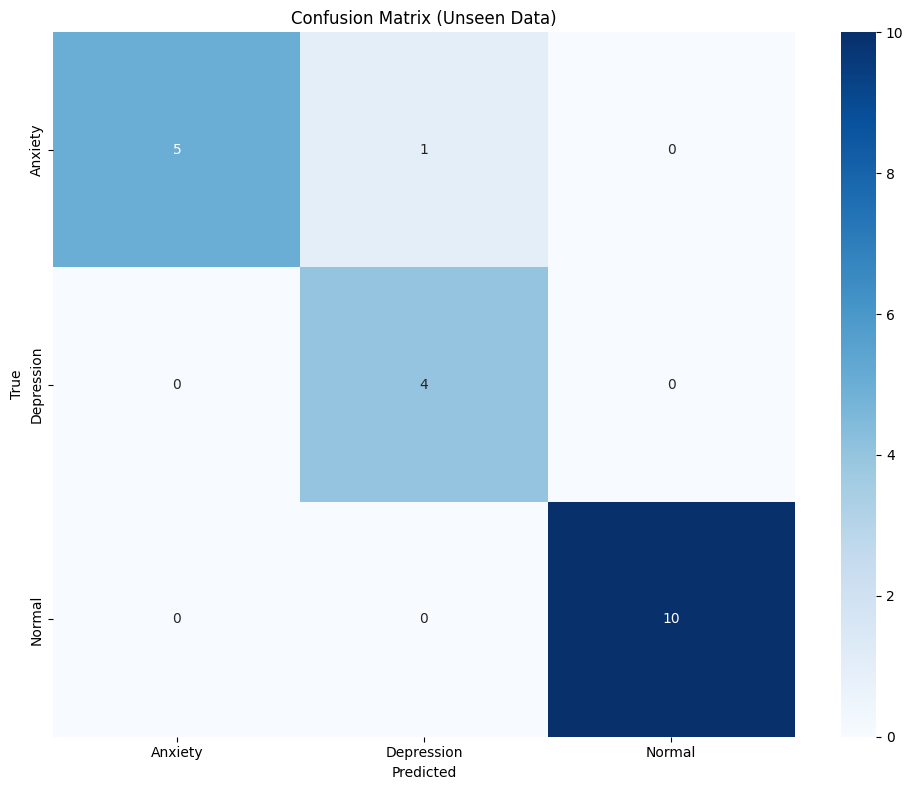

Tested on 20 unseen samples
Accuracy on unseen data: 0.9500

Classification Report on Unseen Data:
              precision    recall  f1-score
Anxiety        1.000000  0.833333  0.909091
Depression     0.800000  1.000000  0.888889
Normal         1.000000  1.000000  1.000000
accuracy       0.950000  0.950000  0.950000
macro avg      0.933333  0.944444  0.932660
weighted avg   0.960000  0.950000  0.950505

LIME ANALYSIS ON UNSEEN DATA EXAMPLES

Unseen Example 1:
Text: පිටරට අවුරුද්දක් තිස්සේ ප්ලෑන් කළා ඒත් වීසා ඉන්ටවිව් හිතද්දි ඇඟ හිරි වැටෙනවා ඊයේ ඉඳන් ලියකියවිලි දහ පාරක් චෙක් කළා පාස්පෝට් බැංකු ස්ටේට්මන්ට් ස්පොන්සර...
True label: Anxiety


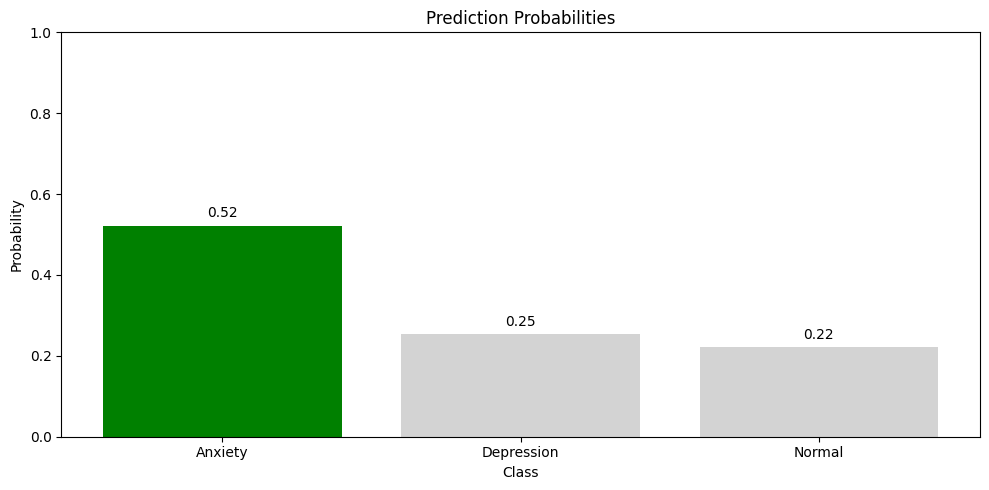

✅ CORRECT PREDICTION: Anxiety (Confidence: 0.5223)

Complete explanation saved to: unseen_lime_explanations/unseen_example_1.html

Unseen Example 2:
Text: විභාග ඉක්මනින් එනවා සියල්ල හොඳින් දවසක් හෘදය වේගයෙන් ගැහෙන්න පටන් ගත්තා ඉන් පසු පසුගිය පුරාම නිදාගන්න උත්සාහ කරන හැම වෙලාවකම එය වේගයෙන් ගැහෙනවා හුස්ම ...
True label: Anxiety


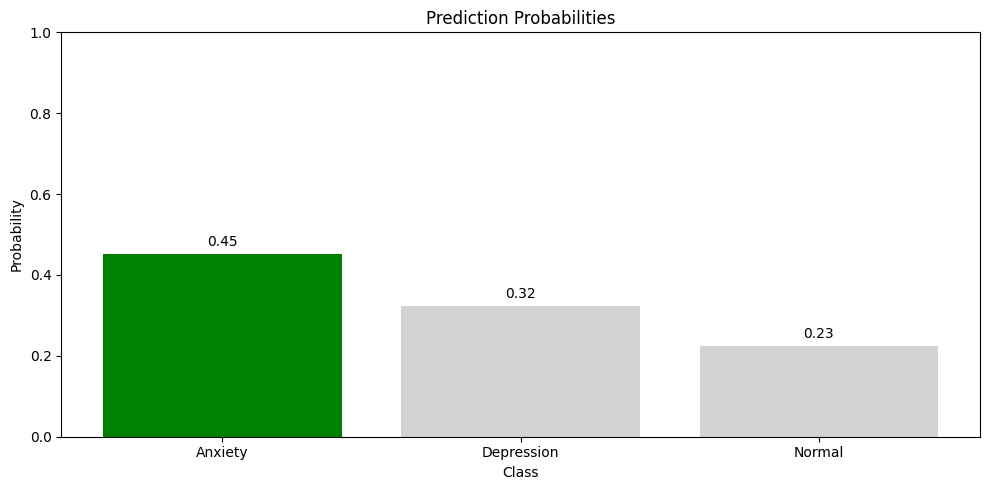

✅ CORRECT PREDICTION: Anxiety (Confidence: 0.4527)

Complete explanation saved to: unseen_lime_explanations/unseen_example_2.html

Unseen Example 3:
Text: කැමති නෙවෙයි සිද්ධ වෙනවා ආසාදනයක් මුල් ඇල සැත්කමක් කළා දන්ත වෛද්යවරයා ස්ථායිතාවයක් කිරීටයක් දාන්න නිර්දේශ පුද්ගලිකව හිතන්නේ මොහොතේ විකල්පයක් මොකද ඉදිර...
True label: Anxiety


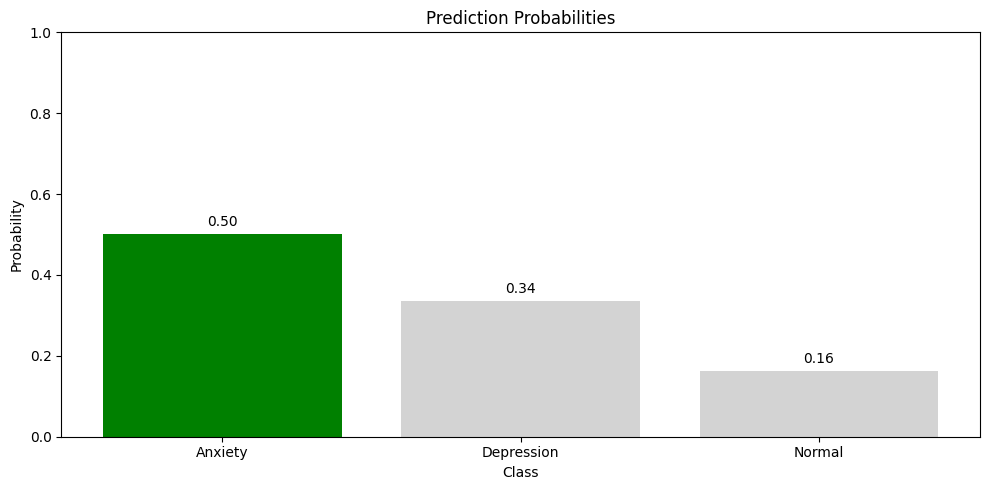

✅ CORRECT PREDICTION: Anxiety (Confidence: 0.5012)

Complete explanation saved to: unseen_lime_explanations/unseen_example_3.html

Unseen Example 4:
Text: පොඩි කාලේ වැස්සට තෙමිලා හැදුණු උණ රෝගය තාමත් වැස්සට බයයි වහින දවස්වලට ගෙදරින් එළියට බැරි තරම් ගෙදර ඉන්න කොටත් ජනෙල් වහලා දොරවල් වහලා ඉන්නේ බිය ජය බැරු...
True label: Anxiety


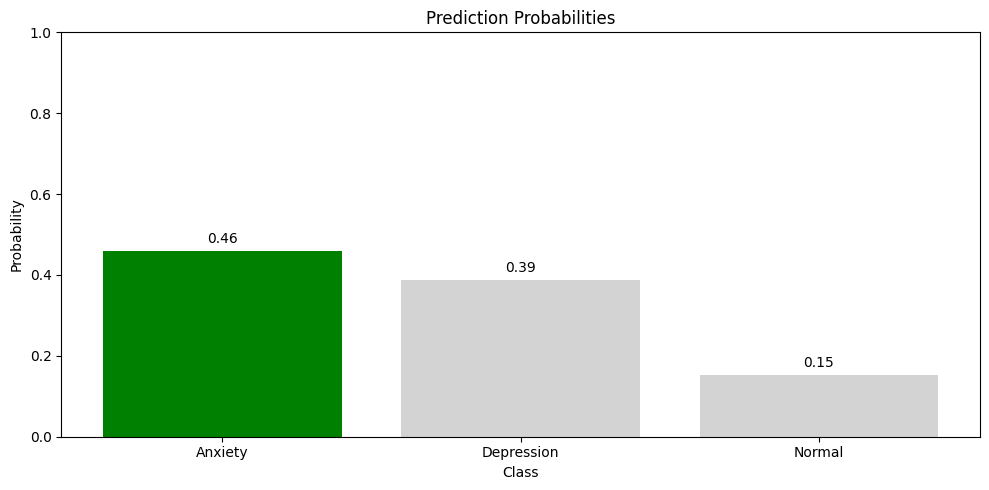

✅ CORRECT PREDICTION: Anxiety (Confidence: 0.4591)

Complete explanation saved to: unseen_lime_explanations/unseen_example_4.html

Unseen Example 5:
Text: කාටවත් කතා දන්නේ තනියම බාර් වලට ගිහින් බැලුවා එතන තනියම වාඩි වෙලා ඉන්නවා සාමාන්යයටත් මෝඩයෙක් පෙනෙනවා ස්ප්රයිට් එකකට සල්ලි නාස්ති හරියටම වැලඳගැනීමක් අව...
True label: Depression


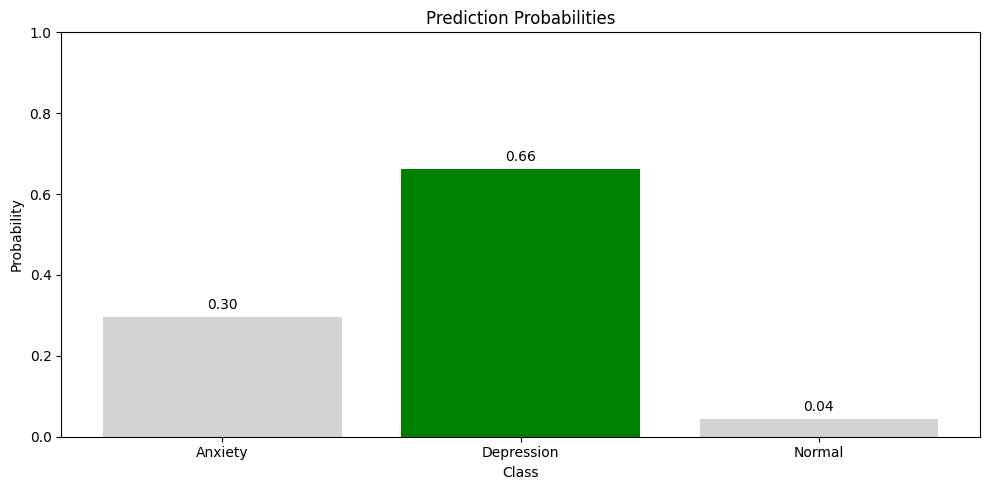

✅ CORRECT PREDICTION: Depression (Confidence: 0.6611)

Complete explanation saved to: unseen_lime_explanations/unseen_example_5.html


In [13]:
# Run the function to test on unseen data
print("\n" + "="*80)
print("TESTING ON UNSEEN DATA")
print("="*80)

# Option 1: Use held-out test data as "unseen" data
unseen_results, unseen_X, unseen_y = test_on_unseen_data(
    best_rf, 
    tfidf_vectorizer, 
    label_encoder,
    data_path=None,  # Set to None to use held-out test data
    sample_size=20   # Test on 20 random samples from test set
)

# Perform LIME analysis on a few unseen examples to check explanations
print("\n" + "="*80)
print("LIME ANALYSIS ON UNSEEN DATA EXAMPLES")
print("="*80)

# Create directory for unseen explanations
unseen_explanation_dir = 'unseen_lime_explanations'
os.makedirs(unseen_explanation_dir, exist_ok=True)

# Select a few examples for detailed analysis
num_examples = min(5, len(unseen_X))
indices = np.random.choice(len(unseen_X), num_examples, replace=False)

for i, idx in enumerate(indices):
    text = unseen_X.iloc[idx]
    true_label = unseen_y[idx]
    
    print(f"\nUnseen Example {i+1}:")
    print(f"Text: {text[:150]}...")
    print(f"True label: {true_label}")
    
    # Generate explanation
    explanation_file = os.path.join(unseen_explanation_dir, f"unseen_example_{i+1}.html")
    explanation, html, exp_data = explain_prediction_with_lime(
        text, 
        tfidf_vectorizer, 
        best_rf, 
        label_encoder,
        num_features=15,
        num_samples=7500,
        save_path=explanation_file
    )
    
    # Check if prediction matches true label
    if exp_data['prediction'] == true_label:
        print(f"✅ CORRECT PREDICTION: {exp_data['prediction']} (Confidence: {exp_data['confidence']:.4f})")
    else:
        print(f"❌ INCORRECT PREDICTION: Got {exp_data['prediction']}, should be {true_label}")
        print(f"   Confidence: {exp_data['confidence']:.4f}")
        
        # Show what confused the model
        print("\nFactors that led to misclassification:")
        for text, score in exp_data['explanations'][exp_data['prediction']]['features'][:5]:
            sign = '+' if score > 0 else ''
            print(f"  {text:<30} : {sign}{score:.4f}")
            
    print(f"\nComplete explanation saved to: {explanation_file}")